<a href="https://colab.research.google.com/github/Fxhdeveloper/CIFAR10-Classifier-in-Pytorch/blob/master/CIFAR10_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Check for GPU**

In [0]:
import torch
import numpy as np

gpu_available = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if gpu_available:
  print(' Training on GPU. ')
else:
  print(' Training on CPU. ')

 Training on GPU. 


### Load Dataset

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
validation_size = 0.2

transforms = transforms.Compose([transforms.RandomRotation(15),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize( [0.5, 0.5, 0.5],[0.5,0.5,0.5] )])

# download dataset
train_data = datasets.CIFAR10('CIFAR10', train=True, download=True, transform=transforms)
test_data = datasets.CIFAR10('CIFAR10', train=False, download=True, transform=transforms)

# indices for splitting the validation and training sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int( np.floor( validation_size * num_train))
train_ids, validation_ids = indices[split:], indices[:split]

# samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_ids)
valid_sampler = SubsetRandomSampler(validation_ids)

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size)

# image classes
classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer','dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# unnormalize and display image
def imshow(image):
    image = image / 2 + 0.5   # unnormalize
    plt.imshow(np.transpose(image, (1, 2, 0))) # convert from tensor image

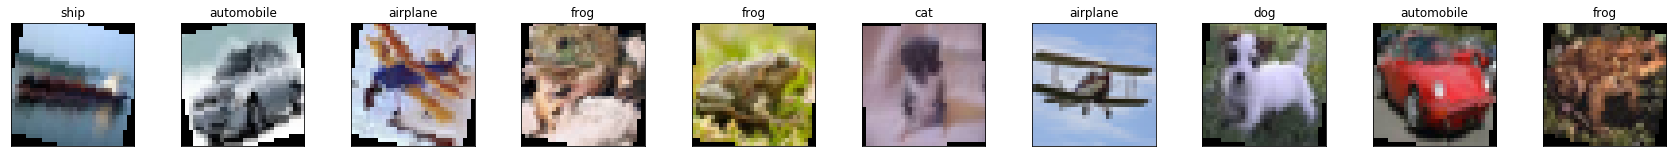

In [0]:
images, labels = next(iter(train_loader))
images = images.numpy() # to numpy for display

fig = plt.figure( figsize=(30,5))
#display 10 images

for i in np.arange(10):
    viz = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    viz.set_title(classes[labels[i]])

### Network Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # conv layer ( sees 32x32x3 tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer ( sees 16x16x16 tensor after maxpooling)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # conv layer ( sees 8x8x32 tensor after maxpooling)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer stride 2 
        self.maxpool = nn.MaxPool2d(2, 2)
        
        # linear layer ( 4x4x64 -> 500)
        self.fc1 = nn.Linear(4*4*64, 500)
        # linear layer (500 -> 100)
        self.fc2 = nn.Linear(500, 100)
        # linear layer (100 -> 10)
        self.fc3 = nn.Linear(100, 10)
        
        # dropout 
        self.dropout = nn.Dropout(0.3)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.maxpool( self.relu( self.conv1(x)))
        x = self.maxpool( self.relu( self.conv2(x)))
        x = self.maxpool( self.relu( self.conv3(x)))
        
        # time to continue with dense net, need to flatten the tensor
        x = x.view(-1, 4*4*64)
        x = self.dropout(x)
        x = self.relu( self.fc1(x))
        x = self.dropout(x)
        x = self.relu( self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x 

In [0]:
model = Classifier()
print(model)

# train on gpu (if available)
model.to(device);

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.3)
  (relu): ReLU()
)


### Loss and Optimizer functions

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

### Time to train the network :)

In [0]:
epochs = 80
validation_loss = np.Inf

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    ################
    # train the model
    ################
    
    model.train()
    for batch_id, (images, labels) in enumerate(train_loader):
        # to gpu if it is available
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
    
    ##################
    # model validation
    ##################
    model.eval()
    for batch_id, (images, labels) in enumerate(valid_loader):
        # to gpu if available
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()*images.size(0)
            
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {}/{} \tTraining Loss: {:.4f} \t Validation Loss: {:.4f}'.format(epoch+1, epochs, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= validation_loss:
        print('Validation loss decreased ({:4f} --> {:4f})). Saving model...'.format(validation_loss, valid_loss))
        torch.save(model.state_dict(), 'CIFAR10 Colab Trained Classifier.pt')
        validation_loss = valid_loss

Epoch: 2/80 	Training Loss: 2.3022 	 Validation Loss: 2.2985
Validation loss decreased ( inf --> 2.298484)). Saving model...
Epoch: 3/80 	Training Loss: 2.2928 	 Validation Loss: 2.2718
Validation loss decreased (2.298484 --> 2.271808)). Saving model...
Epoch: 4/80 	Training Loss: 2.1907 	 Validation Loss: 2.0604
Validation loss decreased (2.271808 --> 2.060414)). Saving model...
Epoch: 5/80 	Training Loss: 2.0472 	 Validation Loss: 1.9857
Validation loss decreased (2.060414 --> 1.985741)). Saving model...
Epoch: 6/80 	Training Loss: 1.9930 	 Validation Loss: 1.9260
Validation loss decreased (1.985741 --> 1.926024)). Saving model...
Epoch: 7/80 	Training Loss: 1.9271 	 Validation Loss: 1.8433
Validation loss decreased (1.926024 --> 1.843264)). Saving model...
Epoch: 8/80 	Training Loss: 1.8481 	 Validation Loss: 1.7701
Validation loss decreased (1.843264 --> 1.770059)). Saving model...
Epoch: 9/80 	Training Loss: 1.7687 	 Validation Loss: 1.6795
Validation loss decreased (1.770059 --> 

In [0]:
model2 = Classifier()
model2.load_state_dict(torch.load('CIFAR10_Colab_Trained_Classifier.pt'))
model2.to(device);
model2.eval()

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.3)
  (relu): ReLU()
)

**Check the accuracy on the testing dataset**

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval()

for batch_id, (images, labels) in enumerate(test_loader):
  # let's move to gpu if available
  images, labels = images.to(device), labels.to(device)
  
  output = model2(images)
  loss = criterion(output, labels)
  test_loss += loss.item()*images.size(0)
  
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
  
  # calc test accuracy for each object class
  for i in range(batch_size):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
#average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))

# let's print for each class
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d / %2d)' % (classes[i], 100*class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]) )
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.7511

Test Accuracy of airplane: 78% (784 / 1000)
Test Accuracy of automobile: 83% (836 / 1000)
Test Accuracy of  bird: 64% (645 / 1000)
Test Accuracy of   cat: 46% (468 / 1000)
Test Accuracy of  deer: 73% (739 / 1000)
Test Accuracy of   dog: 65% (651 / 1000)
Test Accuracy of  frog: 85% (858 / 1000)
Test Accuracy of horse: 75% (759 / 1000)
Test Accuracy of  ship: 87% (879 / 1000)
Test Accuracy of truck: 78% (780 / 1000)

Test Accuracy (Overall): 73% (7399/10000)
